# Plots for the 2MDM analysis

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os,shutil
from pandas import json_normalize

import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
from IPython.display import display, Markdown

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

/var/folders/b3/l10x2d9503j4vrszk86wqw040000gn/T/ipykernel_65556/1200496628.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import glob,imp,os,shutil
/var/folders/b3/l10x2d9503j4vrszk86wqw040000gn/T/ipykernel_65556/1200496628.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


### Scan over $\alpha$ 

In [2]:
#Merge with SModelS DataFrame
# pclFiles = {'all': '../../data/2mdm_results_scan_alpha_v3/all/results.pcl',
#             'zp': '../../data/2mdm_results_scan_alpha_v3/zp_only/results.pcl',
#             'sd': '../../data/2mdm_results_scan_alpha_v3/sd_only/results.pcl'}
# pclFiles = {'sd': '../scan/data/pcl_files/smodels_results_scan_alpha.pcl'}
pclFiles = ['../scan/smodels_results_final.pcl']

dfs = [pd.read_pickle(i) for i in pclFiles]
dataDF = pd.concat(dfs, ignore_index=True)
print(dataDF.columns.values.tolist()) #Print all columns names

['filename', 'mass.9000006', 'mass.9900026', 'mass.9900032', 'mass.9000002', 'mass.9000003', 'mass.9000004', 'mass.9000005', 'width.9000002', 'width.9000003', 'width.9000004', 'width.9000005', 'width.9000006', 'width.9900026', 'width.9900032', 'extpar.1', 'extpar.2', 'extpar.3', 'extpar.4', 'xsec8TeV(fb).9900032', 'xsec8TeV(fb).9900026', 'xsec13TeV(fb).9900032', 'xsec13TeV(fb).9900026', 'BRs.sd.W-,W+', 'BRs.sd.higgs,higgs', 'BRs.sd.Z,Z', 'BRs.sd.t-,t+', 'BRs.sd.chi,chi', 'BRs.sd.ta+,ta-', 'BRs.zp.chi,chi', 'BRs.zp.c,c', 'BRs.zp.q,q', 'BRs.zp.b,b', 'BRs.zp.t-,t+', 'totalxsec13TeV(fb)', 'totalxsec8TeV(fb)', 'CombinedRes', 'Total xsec for missing topologies (fb)', 'Total xsec for missing topologies with displaced decays (fb)', 'Total xsec for missing topologies with prompt decays (fb)', 'Total xsec for topologies outside the grid (fb)', 'OutputStatus.sigmacut', 'OutputStatus.minmassgap', 'OutputStatus.maxcond', 'OutputStatus.ncpus', 'OutputStatus.model', 'OutputStatus.promptwidth', 'Outpu

In [3]:
#Set points without results with r == 0
dataDF.fillna(value={c : 0 for c in dataDF.columns if c.endswith('.r')}, inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

In [4]:
idCols = [c for c in dataDF.columns if 'AnalysisID' in c]
txCols = [c for c in dataDF.columns if 'TxNames' in c and not 'weights' in c]

In [5]:
txCols

['ExptRes.result0.TxNames',
 'ExptRes.result1.TxNames',
 'ExptRes.result2.TxNames',
 'ExptRes.result3.TxNames',
 'ExptRes.result4.TxNames',
 'ExptRes.result5.TxNames',
 'ExptRes.result6.TxNames',
 'ExptRes.result7.TxNames',
 'ExptRes.result8.TxNames']

In [6]:
ana, tx = [], []
for c in idCols:
    for i in dataDF[c].dropna().unique():
        ana.append(i)
        
for c in txCols:
    for txlist in dataDF[c].dropna():
        for i in txlist:
            tx.append(i)

In [7]:
dataDF.T

9182    
filename                                     scan_1_x8s0ganz.slha  \
mass.9000006                                             65.31481   
mass.9900026                                             150.5569   
mass.9900032                                             301.1137   
mass.9000002                                              91.1876   
...                                                           ...   
ExptRes.result6.TxNames weights (fb).TRV1qq                   NaN   
ExptRes.result1.TxNames weights (fb).TRV1jj                   NaN   
ExptRes.result2.TxNames weights (fb).TRV1tt                   NaN   
ExptRes.result8.TxNames weights (fb).TRS1                     NaN   
ExptRes.result5.TxNames weights (fb).TRS1                     NaN   

                                                            20770   
filename                                     scan_1_2nj6ro61.slha  \
mass.9000006                                             70.02504   
mass.9900026                                             132.7409   
mass.9900032                                             265.4818   
mass.9000002                                              91.1876   
...                                                           ...   
ExptRes.result6.TxNames weights (fb).TRV1qq                   NaN   
ExptRes.result1.TxNames weights (fb).TRV1jj                   NaN   
ExptRes.result2.TxNames weights (fb).TRV1tt                   NaN   
ExptRes.result8.TxNames weights (fb).TRS1                     NaN   
ExptRes.result5.TxNames weights (fb).TRS1                     NaN   

                                                            18359   
filename                                     scan_1_9_d4iueu.slha  \
mass.9000006                                             68.05573   
mass.9900026                                                150.1   
mass.9900032                                             300.2001   
mass.9000002                                              91.1876   
...                                                           ...   
ExptRes.result6.TxNames weights (fb).TRV1qq                   NaN   
ExptRes.result1.TxNames weights (fb).TRV1jj                   NaN   
ExptRes.result2.TxNames weights (fb).TRV1tt                   NaN   
ExptRes.result8.TxNames weights (fb).TRS1                     NaN   
ExptRes.result5.TxNames weights (fb).TRS1                     NaN   

                                                            7740    
filename                                     scan_1_523lzen_.slha  \
mass.9000006                                              71.4223   
mass.9900026                                             142.3341   
mass.9900032                                             284.6682   
mass.9000002                                              91.1876   
...                                                           ...   
ExptRes.result6.TxNames weights (fb).TRV1qq                   NaN   
ExptRes.result1.TxNames weights (fb).TRV1jj                   NaN   
ExptRes.result2.TxNames weights (fb).TRV1tt                   NaN   
ExptRes.result8.TxNames weights (fb).TRS1                     NaN   
ExptRes.result5.TxNames weights (fb).TRS1                     NaN   

                                                            17817   
filename                                     scan_1_00j3kb2h.slha  \
mass.9000006                                             79.43782   
mass.9900026                                             131.3705   
mass.9900032                                             262.7409   
mass.9000002                                              91.1876   
...                                                           ...   
ExptRes.result6.TxNames weights (fb).TRV1qq                   NaN   
ExptRes.result1.TxNames weights (fb).TRV1jj                   NaN   
ExptRes.result2.TxNames weights (fb).TRV1tt                   NaN   
ExptRes.result8.TxNames weights (fb).TRS1             

In [8]:
txnames = pd.Series(tx).drop_duplicates().tolist()
analysis = pd.Series(ana).drop_duplicates().tolist()

In [9]:
filteredDF = []
# anaID = analysis
# txID = txnames
for irow,row in dataDF.iterrows():
    for anaID in analysis:
        for txID in txnames:
            # resCols = [idc for idc in idCols if (row[idc] == anaID and (row[idc.replace('AnalysisID','TxNames')] == [txID]
            #                                                            or row[idc.replace('AnalysisID','TxNames')] == ['TRS1', 'TRV1']))]
            resCols = [idc for idc in idCols if (row[idc] == anaID)]
            if not resCols:
                continue
            resCol = resCols[0].rsplit('.',1)[0]
            newrow = {c.replace(resCol,'ExptRes.result') : row[c] for c in dataDF.columns if (('ExptRes' not in c) or (resCol in c))}
            filteredDF.append(newrow)  

In [10]:
newDF = pd.DataFrame.from_dict(filteredDF)

In [11]:
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', None)

In [12]:
newDF.T

0        
filename                                                                         scan_1_x8s0ganz.slha  \
mass.9000006                                                                                 65.31481   
mass.9900026                                                                                 150.5569   
mass.9900032                                                                                 301.1137   
mass.9000002                                                                                  91.1876   
mass.9000003                                                                                 79.82436   
mass.9000004                                                                                 79.82436   
mass.9000005                                                                                   1500.0   
width.9000002                                                                                  2.4952   
width.9000003                                                                                   2.085   
width.9000004                                                                                   2.085   
width.9000005                                                                                    80.0   
width.9000006                                                                                     0.0   
width.9900026                                                                                0.129921   
width.9900032                                                                                13.33022   
extpar.1                                                                                     1.414214   
extpar.2                                                                                         0.25   
extpar.3                                                                                         0.25   
extpar.4                                                                                          0.0   
xsec8TeV(fb).9900032                                                                         705740.0   
xsec8TeV(fb).9900026                                                                           489.81   
xsec13TeV(fb).9900032                                                                       1435000.0   
xsec13TeV(fb).9900026                                                                          1219.0   
BRs.sd.W-,W+                                                                                      NaN   
BRs.sd.higgs,higgs                                                                                NaN   
BRs.sd.Z,Z                                                                                        NaN   
BRs.sd.t-,t+                                                                                      NaN   
BRs.sd.chi,chi                                                                                0.99985   
BRs.sd.ta+,ta-                                                                                0.00015   
BRs.zp.chi,chi                                                                               0.438263   
BRs.zp.c,c                                                                                   0.112348   
BRs.zp.q,q                                                                                   0.112348   
BRs.zp.b,b                                                                                   0.112347   
BRs.zp.t-,t+                                                                                      NaN   
totalxsec13TeV(fb)                                                                          1436219.0   
totalxsec8TeV(fb)                                                                           706229.81   
CombinedRes                                         [{'AnalysisID': 'ATLAS-SUSY-2018-22-multibin,C...   
Total xsec for missing topologies (fb)                                                       0.182818   


In [13]:
# labels = []
# for index, row in newDF.iterrows():
#     ana = row['ExptRes.result.AnalysisID']
#     txList = sorted(row['ExptRes.result.TxNames'])
#     label = ana + ' (' + ','.join(txList) + ')'
#     labels.append(label)
# newDF['label'] = labels
# newDF = newDF.replace(to_replace='CMS-EXO-20-004 (TRS1,TRV1)', value='CMS-EXO-20-004 (TRV1)')


In [14]:
# filter analysis

dfAll = newDF[(newDF['ExptRes.result.AnalysisID']=='CMS-EXO-20-004')]

In [15]:
# plot values of r for sd only
# dfSd = newDF[(newDF['process']=='sd')&(newDF['ExptRes.result.AnalysisID']=='CMS-EXO-20-004')]

In [16]:
# dfSd = dfSd[dfSd['extpar.1']==1.414214]

In [17]:
zpMasses = dfAll['mass.9900032'].unique().tolist()

In [19]:
dfAll = dfAll.drop_duplicates(['filename'])

In [20]:
dfAll.T

9       
filename                                                                         scan_2_d3265jy5.slha  \
mass.9000006                                                                                     65.0   
mass.9900026                                                                                 363.3878   
mass.9900032                                                                                   2000.0   
mass.9000002                                                                                  91.1876   
mass.9000003                                                                                 79.82436   
mass.9000004                                                                                 79.82436   
mass.9000005                                                                                   1500.0   
width.9000002                                                                                  2.4952   
width.9000003                                                                                   2.085   
width.9000004                                                                                   2.085   
width.9000005                                                                                    80.0   
width.9000006                                                                                     0.0   
width.9900026                                                                                4.008348   
width.9900032                                                                                112.3956   
extpar.1                                                                                     1.414214   
extpar.2                                                                                         0.25   
extpar.3                                                                                     0.388929   
extpar.4                                                                                          0.0   
xsec8TeV(fb).9900032                                                                           97.667   
xsec8TeV(fb).9900026                                                                           304.28   
xsec13TeV(fb).9900032                                                                          661.48   
xsec13TeV(fb).9900026                                                                           964.9   
BRs.sd.W-,W+                                                                                 0.445697   
BRs.sd.higgs,higgs                                                                           0.312519   
BRs.sd.Z,Z                                                                                   0.204487   
BRs.sd.t-,t+                                                                                 0.026736   
BRs.sd.chi,chi                                                                               0.010533   
BRs.sd.ta+,ta-                                                                               0.000028   
BRs.zp.chi,chi                                                                                0.46902   
BRs.zp.c,c                                                                                   0.088502   
BRs.zp.q,q                                                                                   0.088502   
BRs.zp.b,b                                                                                   0.088502   
BRs.zp.t-,t+                                                                                 0.088472   
totalxsec13TeV(fb)                                                                            1626.38   
totalxsec8TeV(fb)                                                                             401.947   
Total xsec for missing topologies (fb)                                                       954.7367   
Total xsec for missing topologies with displace...                                                0.0   
T

/var/folders/b3/l10x2d9503j4vrszk86wqw040000gn/T/ipykernel_65556/3604411045.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('Spectral_r')


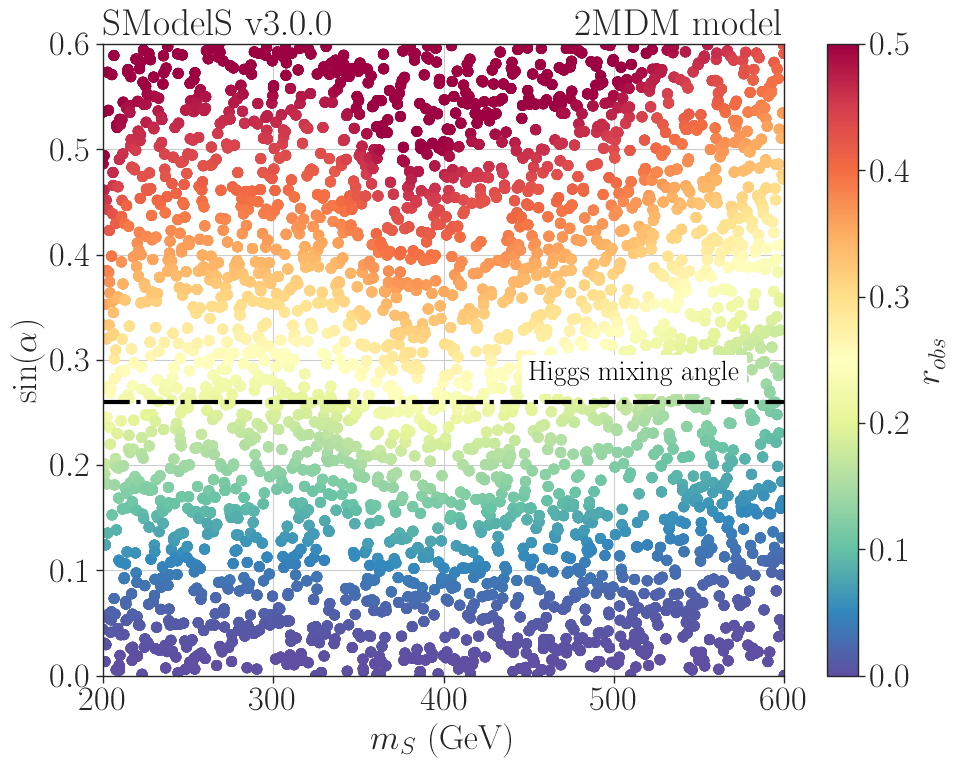

In [21]:
cm = plt.cm.get_cmap('Spectral_r')
plt.figure(figsize=(10,8))

mzp = 2000
data = dfAll[(dfAll['mass.9900032']==mzp)&(dfAll['ExptRes.result.r']>=0)]
data = data.sort_values(['mass.9900026', 'extpar.3'])
x = data['mass.9900026']
y = data['extpar.3']
# weight ratio by scalar contribution
ws = data['ExptRes.result.TxNames weights (fb).TRS1'] 
weight =  ws / (data['ExptRes.result.TxNames weights (fb).TRV1'] + ws)
c = data['ExptRes.result.r'] * weight

plt.hlines(0.26, 200, 600, linestyle='dashdot', color='black',linewidth=3.0)
# plt.plot(atlas_curve['mS'], atlas_curve['sinalpha'])

im = plt.scatter(x,y,c=c,s=50,cmap=cm, vmin=0., vmax=0.5)
cb = plt.colorbar(im)
cb.set_label(label=r'$r_{obs}$', size=25)

#     ax[i].text(0.7,0.9,r"$m_{Z^{\prime}} = %1.2f$ GeV" %mzp,fontsize=15,
#                bbox=dict(facecolor='white', edgecolor='black'), transform=ax[i].transAxes)

plt.ylim(0,0.6)
plt.xlim(200,600)
    
plt.xlabel(r'$m_{S}$ (GeV)', fontsize=25)
plt.ylabel(r'$\sin(\alpha$)', fontsize=25)
    
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
im.figure.axes[0].tick_params(axis="both", labelsize=25) 
im.figure.axes[1].tick_params(axis="y", labelsize=25) 
plt.text(450., 0.28, r'Higgs mixing angle', color='black', backgroundcolor='white', fontsize=20)

plt.title(r'SModelS v3.0.0', loc='left', fontsize=27)
plt.title(r'2MDM model', loc='right', fontsize=27)

plt.grid()
plt.tight_layout()
plt.savefig('./figures/2mdm_rs_updated.png')

plt.show()

In [22]:
weight

329778    1.738099e-02
329779    1.738099e-02
329780    1.738099e-02
329781    1.738099e-02
329782    1.738099e-02
329783    1.738099e-02
387678    6.808871e-01
387679    6.808871e-01
387680    6.808871e-01
387681    6.808871e-01
387682    6.808871e-01
387683    6.808871e-01
343788    5.000880e-01
343789    5.000880e-01
343790    5.000880e-01
343791    5.000880e-01
343792    5.000880e-01
343793    5.000880e-01
354198    7.205592e-01
354199    7.205592e-01
354200    7.205592e-01
354201    7.205592e-01
354202    7.205592e-01
354203    7.205592e-01
341328    3.418524e-01
341329    3.418524e-01
341330    3.418524e-01
341331    3.418524e-01
341332    3.418524e-01
341333    3.418524e-01
386928    6.558801e-01
386929    6.558801e-01
386930    6.558801e-01
386931    6.558801e-01
386932    6.558801e-01
386933    6.558801e-01
368148    6.859311e-01
368149    6.859311e-01
368150    6.859311e-01
368151    6.859311e-01
368152    6.859311e-01
368153    6.859311e-01
362688    8.392814e-03
362689    8

In [23]:
data[['mass.9900026', 'extpar.3', 'BRs.sd.chi,chi', 'ExptRes.result.r', 'filename']]

mass.9900026  extpar.3  BRs.sd.chi,chi  ExptRes.result.r   
329778      200.0000  0.044241             1.0          0.646449  \
329779      200.0000  0.044241             1.0          0.646449   
329780      200.0000  0.044241             1.0          0.646449   
329781      200.0000  0.044241             1.0          0.646449   
329782      200.0000  0.044241             1.0          0.646449   
329783      200.0000  0.044241             1.0          0.646449   
387678      200.1334  0.486284             1.0          0.727102   
387679      200.1334  0.486284             1.0          0.727102   
387680      200.1334  0.486284             1.0          0.727102   
387681      200.1334  0.486284             1.0          0.727102   
387682      200.1334  0.486284             1.0          0.727102   
387683      200.1334  0.486284             1.0          0.727102   
343788      200.2668  0.333285             1.0          0.674329   
343789      200.2668  0.333285             1.0          0.674329   
343790      200.2668  0.333285             1.0          0.674329   
343791      200.2668  0.333285             1.0          0.674329   
343792      200.2668  0.333285             1.0          0.674329   
343793      200.2668  0.333285             1.0          0.674329   
354198      200.4001  0.535516             1.0          0.752442   
354199      200.4001  0.535516             1.0          0.752442   
354200      200.4001  0.535516             1.0          0.752442   
354201      200.4001  0.535516             1.0          0.752442   
354202      200.4001  0.535516             1.0          0.752442   
354203      200.4001  0.535516             1.0          0.752442   
341328      200.5335  0.240534             1.0          0.658351   
341329      200.5335  0.240534             1.0          0.658351   
341330      200.5335  0.240534             1.0          0.658351   
341331      200.5335  0.240534             1.0          0.658351   
341332      200.5335  0.240534             1.0          0.658351   
341333      200.5335  0.240534             1.0          0.658351   
386928      200.6669  0.461203             1.0          0.714350   
386929      200.6669  0.461203             1.0          0.714350   
386930      200.6669  0.461203             1.0          0.714350   
386931      200.6669  0.461203             1.0          0.714350   
386932      200.6669  0.461203             1.0          0.714350   
386933      200.6669  0.461203             1.0          0.714350   
368148      200.8003  0.494086             1.0          0.728918   
368149      200.8003  0.494086             1.0          0.728918   
368150      200.8003  0.494086             1.0          0.728918   
368151      200.8003  0.494086             1.0          0.728918   
368152      200.8003  0.494086             1.0          0.728918   
368153      200.8003  0.494086             1.0          0.728918   
362688      200.9336  0.030782             1.0          0.646270   
362689      200.9336  0.030782             1.0          0.646270   
362690      200.9336  0.030782             1.0          0.646270   
362691      200.9336  0.030782             1.0          0.646270   
362692      200.9336  0.030782             1.0          0.646270   
362693      200.9336  0.030782             1.0          0.646270   
309918      201.0670  0.352545             1.0          0.677843   
309919      201.0670  0.352545             1.0          0.677843   
309920      201.0670  0.352545             1.0          0.677843   
309921      201.0670  0.352545             1.0          0.677843   
309922      201.0670  0.352545             1.0          0.677843   
309923      201.0670  0.352545             1.0          0.677843   
333438      201.2004  0.191548             1.0          0.653061   
333439      201.2004  0.191548             1.0          0.653061   
333440      201.2004  0.191548             1.0          0.653061   
333441      201.2004  0.191548             1.0          0.653061

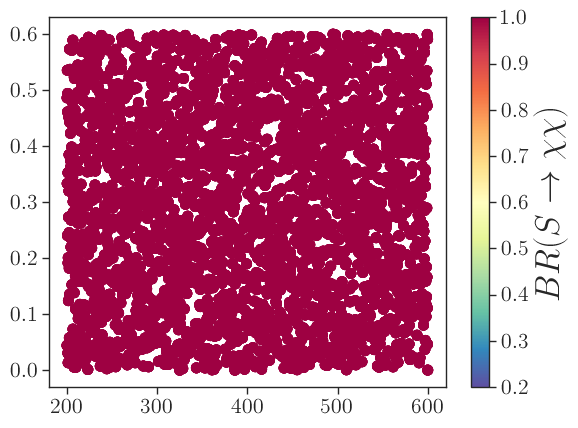

In [24]:
mzp = 2000.0
# data = dfAll[(dfAll['mass.9900032']==mzp)&(dfAll['ExptRes.result.r']>=0)]
x = data['mass.9900026']
y = data['extpar.3']
c = data['BRs.sd.chi,chi']

im = plt.scatter(x,y,c=c,s=50,cmap=cm, vmin=0.2, vmax=1.0)
cb = plt.colorbar(im)
cb.set_label(label=r'$BR(S \to \chi \chi)$', size=25)

plt.show()

In [32]:
(0.6464009/1.470202e-02)*(0.24625976243821482/19.36177)

0.5592079573044467

In [33]:
0.6464009*((0.24625976243821482/1.470202e-02)/(19.11550969041852 + (0.24625976243821482/1.470202e-02)))

0.30188437028710374

In [34]:
0.6746525*(19.11550969041852/35.86557)

0.35957399816634955

In [35]:
0.001895162/1.470202e-02

0.1289048715754706